# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
from torchvision.utils import make_grid

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

real            = torch.from_numpy(data['real_images']).float()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## hyper-parameters

In [3]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 150
size_minibatch  = 50
dim_latent      = 50
dim_channel     = 1
learning_rate_discriminator = 0.001
learning_rate_generator     = 0.001

In [4]:
import random
def affine(image, shear=0, scale=1, rate=[10, 10]):

    func_plt = transforms.functional.to_pil_image
    func_affine = transforms.functional.affine
    func_tensor = transforms.functional.to_tensor

    for i in range(len(image)):

        # random movement
        if rate[0] != 0:
            rate_1 = np.random.randint(-rate[0], rate[0]+1)
            rate_2 = np.random.randint(-rate[1], rate[1]+1)
            movement = [rate_1, rate_2]
        else:
            movement = rate

        if isinstance(scale, list):
            rescale = np.random.randint(scale[0], scale[1]+1) / 10
        else:
            rescale = scale


        trans_image = func_plt(image[i])
        trans_image = func_affine(trans_image, angle=0, shear=shear, scale=rescale, translate=movement)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        if i == 0:
            image_list = trans_image
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)

    return image_list

In [5]:
real_image = real[::2]
affine_12 = affine(real_image, scale=[10, 12], rate=[0, 0])
affine_random = affine(real_image, scale=1, rate=[3, 3])

## custom data loader for the PyTorch framework

In [6]:
class dataset (Dataset):
    def  __init__(self, data):

        self.data = data

    def __getitem__(self, index):

        data = self.data[index]
        data = torch.FloatTensor(data).unsqueeze(dim=0)

        return data
  
    def __len__(self):
        
        return self.data.shape[0]

## construct datasets and dataloaders for training and testing

In [7]:
image_train = np.concatenate([real[1::2], affine_12, affine_random], axis=0)
dataset_real    = dataset(image_train)
dataloader_real = DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

In [8]:
image_train.shape

(6486, 32, 32)

## shape of the data when using the data loader

In [9]:
image_real = dataset_real[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_real.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [10]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=128):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
			# ================================================================================
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
		)	
		
		self.classifier = nn.Sequential(
			# ================================================================================
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			# ================================================================================
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [11]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			# ================================================================================
			nn.Sigmoid(),
			# ================================================================================
		) 			

		# self.initialize_weight()
		
		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass


## build network

In [12]:
generator       = Generator(dim_latent, 1, 128).to(device)
discriminator   = Discriminator(dim_channel, 1, 128).to(device)

optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate_generator, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_discriminator, betas=(0.5, 0.999))

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform


## compute the prediction

In [13]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [14]:
def compute_loss_discriminator(generator, discriminator, latent, data_real):

    data_fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, data_real)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion   = nn.BCEWithLogitsLoss()
    
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    # 
    # ==================================================

    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [15]:
def compute_loss_generator(generator, discriminator, latent):

    data_fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion       = nn.BCEWithLogitsLoss()

    label_real      = torch.ones_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_generator  = criterion(prediction_fake, label_real)
    # 
    # ==================================================

    return loss_generator

## compute the accuracy

In [16]:
def get_center_index(binary_image):
    
    area_square = np.sum(binary_image)

    height = binary_image.shape[0]
    width = binary_image.shape[1]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    indices_X, indices_Y = np.meshgrid(x, y)

    x_mean = np.sum(binary_image * indices_X) / area_square
    y_mean = np.sum(binary_image * indices_Y) / area_square

    return (x_mean, y_mean)

In [17]:
# create ideal square image which has the same area to the input image
def create_label(binary_images):
    
    label = np.zeros_like(binary_images)
    
    for i, binary_image in enumerate(binary_images):
        
        image_height = binary_image.shape[0]
        image_width = binary_image.shape[1]

        square_image = np.zeros((image_height, image_width))
        square_length = np.round(np.sqrt(np.sum(binary_image)))

        if square_length == 0:
            # when there is no square
            return square_image

        (square_center_x, square_center_y) = get_center_index(binary_image)

        if square_center_x < 0 or square_center_x > image_width - 1 or square_center_y < 0 or square_center_y > image_height - 1:
            return square_image

        top = np.ceil(square_center_y - square_length / 2)
        bottom = np.floor(square_center_y + square_length / 2)
        left = np.ceil(square_center_x - square_length / 2)
        right = np.floor(square_center_x + square_length / 2)

        top = int(top) if top >= 0 else 0
        bottom = int(bottom) if bottom <= image_height - 1 else image_height - 1
        left = int(left) if left >= 0 else 0
        right = int(right) if right <= image_width - 1 else image_width - 1

        square_image[top : bottom + 1, left : right + 1] = 1
        
        label[i] = square_image
        
    return label

In [18]:
def compute_accuracy(prediction):

    prediction  = prediction.squeeze(axis=1)
    
    prediction_binary   = (prediction >= 0.5).cpu().numpy().astype(int)
    label               = create_label(prediction_binary).astype(int)
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [19]:
loss_generator_mean     = np.zeros(number_epoch)
loss_generator_std      = np.zeros(number_epoch)
loss_discriminator_mean = np.zeros(number_epoch)
loss_discriminator_std  = np.zeros(number_epoch)

accuracy_mean   = np.zeros(number_epoch)
accuracy_std    = np.zeros(number_epoch)

## train

In [20]:
def train(generator, discriminator, dataloader):

    loss_epoch_generator      = []
    loss_epoch_discriminator  = []
    accuracy_epoch = []
    
    for index_batch, data_real in enumerate(dataloader):

        size_batch  = len(data_real)
        data_real   = data_real.to(device)
        
        latent  = torch.randn(size_batch, dim_latent, device=device)
        latent  = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, data_real)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)

        loss_epoch_generator.append(loss_generator.item())
        loss_epoch_discriminator.append(loss_discriminator.item())
        accuracy_epoch.append(accuracy)

    loss_generator_mean_epoch       = np.mean(loss_epoch_generator)
    loss_generator_std_epoch        = np.std(loss_epoch_generator)
    
    loss_discriminator_mean_epoch   = np.mean(loss_epoch_discriminator)
    loss_discriminator_std_epoch    = np.std(loss_epoch_discriminator)

    accuracy_mean_epoch             = np.mean(accuracy_epoch)
    accuracy_std_epoch              = np.std(accuracy_epoch)

    loss_value_generator        = {'mean' : loss_generator_mean_epoch, 'std' : loss_generator_std_epoch}
    loss_value_discriminator    = {'mean' : loss_discriminator_mean_epoch, 'std' : loss_discriminator_std_epoch}
    accuracy_value              = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch} 

    return loss_value_generator, loss_value_discriminator, accuracy_value


## training epoch

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_value_generator, loss_value_discriminator, accuracy_value) = train(generator, discriminator, dataloader_real)

    loss_generator_mean[i]      = loss_value_generator['mean']
    loss_generator_std[i]       = loss_value_generator['std']

    loss_discriminator_mean[i]  = loss_value_discriminator['mean']
    loss_discriminator_std[i]   = loss_value_discriminator['std']

    accuracy_mean[i]            = accuracy_value['mean']
    accuracy_std[i]             = accuracy_value['std']

    print(f"epoch : {i}")
    print(f"\tloss_value_discriminator : {loss_value_discriminator['mean']}, acc mean : {accuracy_value['mean']}")

  1%|          | 1/150 [00:26<1:05:55, 26.55s/it]

epoch : 0
	loss_value_discriminator : 6294.682165419986, acc mean : 80.3810461153594


  1%|▏         | 2/150 [00:53<1:05:21, 26.50s/it]

epoch : 1
	loss_value_discriminator : 4.647765823533441, acc mean : 77.41363175641071


  2%|▏         | 3/150 [01:19<1:04:53, 26.49s/it]

epoch : 2
	loss_value_discriminator : 6.519101020156921, acc mean : 66.38650101220453


  3%|▎         | 4/150 [01:45<1:04:26, 26.48s/it]

epoch : 3
	loss_value_discriminator : 3.293772342737111, acc mean : 64.11469527075222


  3%|▎         | 5/150 [02:12<1:03:58, 26.48s/it]

epoch : 4
	loss_value_discriminator : 2.4256779315826824, acc mean : 61.522210372814044


  4%|▍         | 6/150 [02:38<1:03:30, 26.46s/it]

epoch : 5
	loss_value_discriminator : 0.23854360270850294, acc mean : 57.65095293062823


  5%|▍         | 7/150 [03:05<1:03:06, 26.48s/it]

epoch : 6
	loss_value_discriminator : 0.16960322744932294, acc mean : 69.9903991009297


  5%|▌         | 8/150 [03:31<1:02:38, 26.47s/it]

epoch : 7
	loss_value_discriminator : 0.8976365907376952, acc mean : 75.43179698021132


  6%|▌         | 9/150 [03:58<1:02:11, 26.46s/it]

epoch : 8
	loss_value_discriminator : 0.7818626098119345, acc mean : 70.85811103521007


  7%|▋         | 10/150 [04:24<1:01:43, 26.45s/it]

epoch : 9
	loss_value_discriminator : 0.08018860644051176, acc mean : 75.04654489652727


  7%|▋         | 11/150 [04:51<1:01:15, 26.44s/it]

epoch : 10
	loss_value_discriminator : 0.17752588030393676, acc mean : 77.1235447019984


  8%|▊         | 12/150 [05:17<1:00:48, 26.44s/it]

epoch : 11
	loss_value_discriminator : 0.07789861828281884, acc mean : 83.46712948679368


  9%|▊         | 13/150 [05:44<1:00:22, 26.44s/it]

epoch : 12
	loss_value_discriminator : 0.25225852128997484, acc mean : 85.83738278997836


  9%|▉         | 14/150 [06:10<59:58, 26.46s/it]  

epoch : 13
	loss_value_discriminator : 23.17478053566509, acc mean : 70.26944759777368


 10%|█         | 15/150 [06:36<59:33, 26.47s/it]

epoch : 14
	loss_value_discriminator : 0.34476974825988443, acc mean : 64.31199882641381


 11%|█         | 16/150 [07:03<59:08, 26.48s/it]

epoch : 15
	loss_value_discriminator : 0.22121032659513082, acc mean : 66.89183798016236


 11%|█▏        | 17/150 [07:29<58:40, 26.47s/it]

epoch : 16
	loss_value_discriminator : 0.1348911293226388, acc mean : 68.0278070853373


 12%|█▏        | 18/150 [07:56<58:12, 26.46s/it]

epoch : 17
	loss_value_discriminator : 0.09425931309111589, acc mean : 73.9727738615017


 13%|█▎        | 19/150 [08:22<57:44, 26.44s/it]

epoch : 18
	loss_value_discriminator : 0.09828940384061069, acc mean : 74.64726628466397


 13%|█▎        | 20/150 [08:49<57:16, 26.44s/it]

epoch : 19
	loss_value_discriminator : 0.4759770341762594, acc mean : 75.38615295421874


 14%|█▍        | 21/150 [09:15<56:50, 26.44s/it]

epoch : 20
	loss_value_discriminator : 0.11913086266018623, acc mean : 76.77448270464235


 15%|█▍        | 22/150 [09:42<56:23, 26.43s/it]

epoch : 21
	loss_value_discriminator : 0.11925526793194256, acc mean : 76.090276662403


 15%|█▌        | 23/150 [10:08<55:54, 26.41s/it]

epoch : 22
	loss_value_discriminator : 6400049.855324075, acc mean : 67.4758812636875


 16%|█▌        | 24/150 [10:34<55:28, 26.42s/it]

epoch : 23
	loss_value_discriminator : 9942.473857162535, acc mean : 73.57023632429767


 17%|█▋        | 25/150 [11:01<55:01, 26.41s/it]

epoch : 24
	loss_value_discriminator : 3702.413868630579, acc mean : 68.41172183316615


 17%|█▋        | 26/150 [11:27<54:34, 26.41s/it]

epoch : 25
	loss_value_discriminator : 2928.8097943760627, acc mean : 66.87712839089605


 18%|█▊        | 27/150 [11:54<54:07, 26.40s/it]

epoch : 26
	loss_value_discriminator : 1692.0084180905837, acc mean : 67.52808564298492


 19%|█▊        | 28/150 [12:20<53:41, 26.40s/it]

epoch : 27
	loss_value_discriminator : 3694.8520999435304, acc mean : 67.83126602025372


 19%|█▉        | 29/150 [12:46<53:14, 26.40s/it]

epoch : 28
	loss_value_discriminator : 2589.626736175182, acc mean : 70.53352937412981


 20%|██        | 30/150 [13:13<52:48, 26.40s/it]

epoch : 29
	loss_value_discriminator : 4056.1898526332175, acc mean : 57.78039504369387


 21%|██        | 31/150 [13:39<52:20, 26.39s/it]

epoch : 30
	loss_value_discriminator : 2242.982207630032, acc mean : 69.05525499517915


 21%|██▏       | 32/150 [14:06<51:54, 26.39s/it]

epoch : 31
	loss_value_discriminator : 2726.33036023517, acc mean : 71.12516517349167


 22%|██▏       | 33/150 [14:32<51:28, 26.40s/it]

epoch : 32
	loss_value_discriminator : 3645.951947559682, acc mean : 64.33564953733632


 23%|██▎       | 34/150 [14:58<51:01, 26.39s/it]

epoch : 33
	loss_value_discriminator : 470.65648828550826, acc mean : 68.98618060417225


 23%|██▎       | 35/150 [15:25<50:33, 26.38s/it]

epoch : 34
	loss_value_discriminator : 1708.1310173596523, acc mean : 65.9783371043369


 24%|██▍       | 36/150 [15:51<50:06, 26.38s/it]

epoch : 35
	loss_value_discriminator : 2797.138718154079, acc mean : 61.83363399682435


 25%|██▍       | 37/150 [16:17<49:40, 26.38s/it]

epoch : 36
	loss_value_discriminator : 4498.277182697326, acc mean : 70.33579580287325


 25%|██▌       | 38/150 [16:44<49:15, 26.38s/it]

epoch : 37
	loss_value_discriminator : 857.5049514955329, acc mean : 75.33061974033882


 26%|██▌       | 39/150 [17:10<48:50, 26.40s/it]

epoch : 38
	loss_value_discriminator : 2673.4741291094197, acc mean : 55.312235231244316


 27%|██▋       | 40/150 [17:37<48:23, 26.40s/it]

epoch : 39
	loss_value_discriminator : 545.2686287894729, acc mean : 56.289015999834994


 27%|██▋       | 41/150 [18:03<47:57, 26.40s/it]

epoch : 40
	loss_value_discriminator : 470.24869139989215, acc mean : 60.52601086044509


 28%|██▊       | 42/150 [18:29<47:29, 26.39s/it]

epoch : 41
	loss_value_discriminator : 654.2586489740269, acc mean : 64.09390847829481


 29%|██▊       | 43/150 [18:56<47:03, 26.38s/it]

epoch : 42
	loss_value_discriminator : 1350.6273285584857, acc mean : 65.59813651028372


 29%|██▉       | 44/150 [19:22<46:36, 26.39s/it]

epoch : 43
	loss_value_discriminator : 740.7800366749135, acc mean : 62.7450844027266


 30%|███       | 45/150 [19:49<46:10, 26.39s/it]

epoch : 44
	loss_value_discriminator : 5978.372466863588, acc mean : 50.622574647447806


 31%|███       | 46/150 [20:15<45:43, 26.38s/it]

epoch : 45
	loss_value_discriminator : 771.5544790334479, acc mean : 51.687077460221744


 31%|███▏      | 47/150 [20:41<45:16, 26.38s/it]

epoch : 46
	loss_value_discriminator : 356.2476016939148, acc mean : 57.16819186170042


 32%|███▏      | 48/150 [21:08<44:49, 26.37s/it]

epoch : 47
	loss_value_discriminator : 5597.191168792488, acc mean : 72.45884373161023


 33%|███▎      | 49/150 [21:34<44:23, 26.37s/it]

epoch : 48
	loss_value_discriminator : 910.3625742401495, acc mean : 71.89289566163515


 33%|███▎      | 50/150 [22:00<43:57, 26.37s/it]

epoch : 49
	loss_value_discriminator : 55.4087880452474, acc mean : 82.55667570417556


 34%|███▍      | 51/150 [22:27<43:31, 26.38s/it]

epoch : 50
	loss_value_discriminator : 615.0419186436852, acc mean : 82.96503791634035


 35%|███▍      | 52/150 [22:53<43:04, 26.37s/it]

epoch : 51
	loss_value_discriminator : 1142.0031764821488, acc mean : 66.12071827942313


 35%|███▌      | 53/150 [23:20<42:38, 26.37s/it]

epoch : 52
	loss_value_discriminator : 515.0288180639577, acc mean : 69.2197139173221


 36%|███▌      | 54/150 [23:46<42:11, 26.37s/it]

epoch : 53
	loss_value_discriminator : 387.29374199505, acc mean : 73.89522442354814


 37%|███▋      | 55/150 [24:12<41:44, 26.36s/it]

epoch : 54
	loss_value_discriminator : 134.63289433486702, acc mean : 84.93564665696368


 37%|███▋      | 56/150 [24:39<41:18, 26.37s/it]

epoch : 55
	loss_value_discriminator : 321.5025682190592, acc mean : 80.73398318941163


 38%|███▊      | 57/150 [25:05<40:51, 26.36s/it]

epoch : 56
	loss_value_discriminator : 10.82012997787128, acc mean : 80.41801976010032


 39%|███▊      | 58/150 [25:31<40:25, 26.37s/it]

epoch : 57
	loss_value_discriminator : 9.668703951576884, acc mean : 81.58742605231784


 39%|███▉      | 59/150 [25:58<39:59, 26.37s/it]

epoch : 58
	loss_value_discriminator : 104.20033579695132, acc mean : 81.28237713181875


 40%|████      | 60/150 [26:24<39:33, 26.37s/it]

epoch : 59
	loss_value_discriminator : 65.19937780812245, acc mean : 81.25359082153872


 41%|████      | 61/150 [26:50<39:06, 26.37s/it]

epoch : 60
	loss_value_discriminator : 2199.7951264714084, acc mean : 72.25702160795586


 41%|████▏     | 62/150 [27:17<38:40, 26.37s/it]

epoch : 61
	loss_value_discriminator : 558.6443054509717, acc mean : 81.07658223841379


 42%|████▏     | 63/150 [27:43<38:13, 26.36s/it]

epoch : 62
	loss_value_discriminator : 48.71095012717469, acc mean : 84.34318107720114


 43%|████▎     | 64/150 [28:10<37:47, 26.36s/it]

epoch : 63
	loss_value_discriminator : 179.51154748506323, acc mean : 82.23748215283264


 43%|████▎     | 65/150 [28:36<37:20, 26.36s/it]

epoch : 64
	loss_value_discriminator : 53590.24619186756, acc mean : 87.16421085799166


 44%|████▍     | 66/150 [29:02<36:54, 26.36s/it]

epoch : 65
	loss_value_discriminator : 6363.992434452671, acc mean : 54.48612157479334


 45%|████▍     | 67/150 [29:29<36:28, 26.37s/it]

epoch : 66
	loss_value_discriminator : 378.41034600161765, acc mean : 47.44444074811294


 45%|████▌     | 68/150 [29:55<36:02, 26.37s/it]

epoch : 67
	loss_value_discriminator : 230.10753698034804, acc mean : 65.40404604534915


 46%|████▌     | 69/150 [30:21<35:36, 26.37s/it]

epoch : 68
	loss_value_discriminator : 132.90908022767815, acc mean : 77.07362844773915


 47%|████▋     | 70/150 [30:48<35:10, 26.38s/it]

epoch : 69
	loss_value_discriminator : 46.03503513890644, acc mean : 79.02492911873165


 47%|████▋     | 71/150 [31:14<34:44, 26.39s/it]

epoch : 70
	loss_value_discriminator : 0.9085001326346582, acc mean : 81.20008894162956


 48%|████▊     | 72/150 [31:40<34:17, 26.37s/it]

epoch : 71
	loss_value_discriminator : 10.816107509672179, acc mean : 82.43218389195518


 49%|████▊     | 73/150 [32:07<33:50, 26.38s/it]

epoch : 72
	loss_value_discriminator : 0.24540705380343913, acc mean : 86.06292247967751


 49%|████▉     | 74/150 [32:33<33:24, 26.38s/it]

epoch : 73
	loss_value_discriminator : 4.092774694280107, acc mean : 89.29742306517643


 50%|█████     | 75/150 [33:00<32:58, 26.39s/it]

epoch : 74
	loss_value_discriminator : 8.22842984236488, acc mean : 93.47880866983033


 51%|█████     | 76/150 [33:26<32:32, 26.39s/it]

epoch : 75
	loss_value_discriminator : 0.0, acc mean : 96.04297959043598


 51%|█████▏    | 77/150 [33:52<32:06, 26.39s/it]

epoch : 76
	loss_value_discriminator : 0.24060254688410795, acc mean : 96.47653108372998


 52%|█████▏    | 78/150 [34:19<31:39, 26.39s/it]

epoch : 77
	loss_value_discriminator : 1.082893221877342, acc mean : 96.64353860283776


 53%|█████▎    | 79/150 [34:45<31:13, 26.38s/it]

epoch : 78
	loss_value_discriminator : 0.11663591769314552, acc mean : 96.958422587313


 53%|█████▎    | 80/150 [35:12<30:46, 26.38s/it]

epoch : 79
	loss_value_discriminator : 0.6075740858565929, acc mean : 97.05736856669442


 54%|█████▍    | 81/150 [35:38<30:20, 26.38s/it]

epoch : 80
	loss_value_discriminator : 0.0021144223305606105, acc mean : 97.2963877526765


 55%|█████▍    | 82/150 [36:04<29:53, 26.37s/it]

epoch : 81
	loss_value_discriminator : 1.027275421822718, acc mean : 97.56271564606011


 55%|█████▌    | 83/150 [36:31<29:26, 26.37s/it]

epoch : 82
	loss_value_discriminator : 525.4329373818035, acc mean : 97.1215831298108


 56%|█████▌    | 84/150 [36:57<29:00, 26.37s/it]

epoch : 83
	loss_value_discriminator : 20421.942452037056, acc mean : 76.72377556329744


 57%|█████▋    | 85/150 [37:23<28:33, 26.37s/it]

epoch : 84
	loss_value_discriminator : 233.83061096187708, acc mean : 76.22794356273232


 57%|█████▋    | 86/150 [37:50<28:08, 26.38s/it]

epoch : 85
	loss_value_discriminator : 101.48566193417523, acc mean : 75.14873855488983


 58%|█████▊    | 87/150 [38:16<27:41, 26.38s/it]

epoch : 86
	loss_value_discriminator : 22.600318332513172, acc mean : 75.40866286576671


 59%|█████▊    | 88/150 [38:43<27:15, 26.38s/it]

epoch : 87
	loss_value_discriminator : 2.0665463373593242, acc mean : 76.2308834563761


 59%|█████▉    | 89/150 [39:09<26:49, 26.38s/it]

epoch : 88
	loss_value_discriminator : 0.6625048983557226, acc mean : 77.44472156604775


 60%|██████    | 90/150 [39:35<26:22, 26.38s/it]

epoch : 89
	loss_value_discriminator : 5.572144648843958, acc mean : 78.3105578883498


 61%|██████    | 91/150 [40:02<25:56, 26.39s/it]

epoch : 90
	loss_value_discriminator : 0.15158669729233817, acc mean : 79.90061886116061


 61%|██████▏   | 92/150 [40:28<25:30, 26.38s/it]

epoch : 91
	loss_value_discriminator : 2.0727676633138987, acc mean : 82.81051554475516


 62%|██████▏   | 93/150 [40:54<25:03, 26.38s/it]

epoch : 92
	loss_value_discriminator : 9.631547938341077, acc mean : 82.79030498742611


 63%|██████▎   | 94/150 [41:21<24:37, 26.38s/it]

epoch : 93
	loss_value_discriminator : 21.075757156239117, acc mean : 76.91210449457368


 63%|██████▎   | 95/150 [41:47<24:11, 26.38s/it]

epoch : 94
	loss_value_discriminator : 1.8650257875059926, acc mean : 84.26519535506459


 64%|██████▍   | 96/150 [42:14<23:45, 26.39s/it]

epoch : 95
	loss_value_discriminator : 2.1925175993941552, acc mean : 90.84513841325077


 65%|██████▍   | 97/150 [42:40<23:18, 26.39s/it]

epoch : 96
	loss_value_discriminator : 0.08076284473487573, acc mean : 95.14858691552558


 65%|██████▌   | 98/150 [43:06<22:52, 26.39s/it]

epoch : 97
	loss_value_discriminator : 0.23836157303447872, acc mean : 96.45184203591533


 66%|██████▌   | 99/150 [43:33<22:25, 26.39s/it]

epoch : 98
	loss_value_discriminator : 2.1882262007557145, acc mean : 96.3958333159201


 67%|██████▋   | 100/150 [43:59<21:59, 26.39s/it]

epoch : 99
	loss_value_discriminator : 11467.204384024633, acc mean : 80.75830216378846


 67%|██████▋   | 101/150 [44:26<21:33, 26.40s/it]

epoch : 100
	loss_value_discriminator : 226.4603429690812, acc mean : 51.895012613827156


 68%|██████▊   | 102/150 [44:52<21:07, 26.40s/it]

epoch : 101
	loss_value_discriminator : 132.02814048944518, acc mean : 62.809551255367936


 69%|██████▊   | 103/150 [45:18<20:40, 26.40s/it]

epoch : 102
	loss_value_discriminator : 125.87968967496887, acc mean : 66.91615227653354


 69%|██████▉   | 104/150 [45:45<20:14, 26.40s/it]

epoch : 103
	loss_value_discriminator : 10.57824695433757, acc mean : 82.4967556679751


 70%|███████   | 105/150 [46:11<19:47, 26.38s/it]

epoch : 104
	loss_value_discriminator : 25.03299590165532, acc mean : 83.35766400159163


 71%|███████   | 106/150 [46:38<19:20, 26.38s/it]

epoch : 105
	loss_value_discriminator : 8.69481952717136, acc mean : 84.49485423365074


 71%|███████▏  | 107/150 [47:04<18:54, 26.38s/it]

epoch : 106
	loss_value_discriminator : 6.447196531350188, acc mean : 83.84532613266543


 72%|███████▏  | 108/150 [47:30<18:28, 26.38s/it]

epoch : 107
	loss_value_discriminator : 27.741303673449277, acc mean : 82.92004941919576


 73%|███████▎  | 109/150 [47:57<18:01, 26.38s/it]

epoch : 108
	loss_value_discriminator : 18.974801806169886, acc mean : 78.94670991573281


 73%|███████▎  | 110/150 [48:23<17:35, 26.38s/it]

epoch : 109
	loss_value_discriminator : 6.422192940984279, acc mean : 78.37190008104068


 74%|███████▍  | 111/150 [48:49<17:08, 26.38s/it]

epoch : 110
	loss_value_discriminator : 10.81384561902274, acc mean : 79.95486628880725


 75%|███████▍  | 112/150 [49:16<16:41, 26.37s/it]

epoch : 111
	loss_value_discriminator : 8.2953531603178, acc mean : 81.49321880191762


 75%|███████▌  | 113/150 [49:42<16:15, 26.37s/it]

epoch : 112
	loss_value_discriminator : 4.371917064191766, acc mean : 82.92256995935601


 76%|███████▌  | 114/150 [50:09<15:49, 26.36s/it]

epoch : 113
	loss_value_discriminator : 3.8458157238299786, acc mean : 84.50778069919718


 77%|███████▋  | 115/150 [50:35<15:22, 26.36s/it]

epoch : 114
	loss_value_discriminator : 2.150472315063794, acc mean : 85.07159850008715


 77%|███████▋  | 116/150 [51:01<14:56, 26.37s/it]

epoch : 115
	loss_value_discriminator : 2.084258880262159, acc mean : 84.97133877105985


 78%|███████▊  | 117/150 [51:28<14:29, 26.36s/it]

epoch : 116
	loss_value_discriminator : 1.9187992389973827, acc mean : 84.06411903458563


 79%|███████▊  | 118/150 [51:54<14:03, 26.35s/it]

epoch : 117
	loss_value_discriminator : 3.57838006330133, acc mean : 81.24687553600097


 79%|███████▉  | 119/150 [52:20<13:36, 26.34s/it]

epoch : 118
	loss_value_discriminator : 3.388600763222275, acc mean : 78.81593843999022


 80%|████████  | 120/150 [52:47<13:10, 26.35s/it]

epoch : 119
	loss_value_discriminator : 15.105513139086407, acc mean : 75.81000970201498


 81%|████████  | 121/150 [53:13<12:44, 26.35s/it]

epoch : 120
	loss_value_discriminator : 8.78211508980093, acc mean : 73.32119318689486


 81%|████████▏ | 122/150 [53:39<12:17, 26.34s/it]

epoch : 121
	loss_value_discriminator : 4.141095307574412, acc mean : 70.95765294643479


 82%|████████▏ | 123/150 [54:06<11:51, 26.34s/it]

epoch : 122
	loss_value_discriminator : 4.9472805096428525, acc mean : 70.16843903144589


 83%|████████▎ | 124/150 [54:32<11:24, 26.34s/it]

epoch : 123
	loss_value_discriminator : 3.4034997018030664, acc mean : 71.51681506355501


 83%|████████▎ | 125/150 [54:58<10:58, 26.34s/it]

epoch : 124
	loss_value_discriminator : 3.1507173669418576, acc mean : 72.58456103808969


 84%|████████▍ | 126/150 [55:25<10:31, 26.32s/it]

epoch : 125
	loss_value_discriminator : 1.5437525955433309, acc mean : 72.8730178752962


 85%|████████▍ | 127/150 [55:51<10:05, 26.31s/it]

epoch : 126
	loss_value_discriminator : 4.535011358351521, acc mean : 72.1436256834017


 85%|████████▌ | 128/150 [56:17<09:38, 26.31s/it]

epoch : 127
	loss_value_discriminator : 1.096350574232187, acc mean : 71.05278932566259


 86%|████████▌ | 129/150 [56:43<09:12, 26.31s/it]

epoch : 128
	loss_value_discriminator : 1.6691398987992918, acc mean : 71.1278227947341


 87%|████████▋ | 130/150 [57:10<08:46, 26.34s/it]

epoch : 129
	loss_value_discriminator : 1.8609695150171377, acc mean : 71.56503171981916


 87%|████████▋ | 131/150 [57:36<08:20, 26.36s/it]

epoch : 130
	loss_value_discriminator : 0.5259329058275479, acc mean : 72.8215928496384


 88%|████████▊ | 132/150 [58:03<07:54, 26.37s/it]

epoch : 131
	loss_value_discriminator : 0.7514695088060038, acc mean : 73.55894924069999


 89%|████████▊ | 133/150 [58:29<07:28, 26.38s/it]

epoch : 132
	loss_value_discriminator : 1.1227596112656657, acc mean : 72.11313754612645


 89%|████████▉ | 134/150 [58:55<07:02, 26.38s/it]

epoch : 133
	loss_value_discriminator : 1.3097898093416906, acc mean : 71.24124832902189


 90%|█████████ | 135/150 [59:22<06:35, 26.38s/it]

epoch : 134
	loss_value_discriminator : 0.8384396782080785, acc mean : 71.52491107400058


 91%|█████████ | 136/150 [59:48<06:09, 26.38s/it]

epoch : 135
	loss_value_discriminator : 0.8863480799882292, acc mean : 72.94502957067841


 91%|█████████▏| 137/150 [1:00:15<05:43, 26.39s/it]

epoch : 136
	loss_value_discriminator : 29.566117840450865, acc mean : 67.67053393657027


 92%|█████████▏| 138/150 [1:00:41<05:16, 26.38s/it]

epoch : 137
	loss_value_discriminator : 2352561.2890770934, acc mean : 76.3735370293146


 93%|█████████▎| 139/150 [1:01:07<04:49, 26.30s/it]

epoch : 138
	loss_value_discriminator : 573.1802888849909, acc mean : 65.20345539193069


 93%|█████████▎| 140/150 [1:01:33<04:22, 26.30s/it]

epoch : 139
	loss_value_discriminator : 236.65758182466493, acc mean : 78.19505816081465


 94%|█████████▍| 141/150 [1:02:00<03:56, 26.31s/it]

epoch : 140
	loss_value_discriminator : 112.24712108410606, acc mean : 81.95106792021728


 95%|█████████▍| 142/150 [1:02:26<03:30, 26.31s/it]

epoch : 141
	loss_value_discriminator : 66.94917328413143, acc mean : 79.20721787453348


 95%|█████████▌| 143/150 [1:02:52<03:04, 26.29s/it]

epoch : 142
	loss_value_discriminator : 239.33806364342223, acc mean : 80.36382652491118


 96%|█████████▌| 144/150 [1:03:19<02:37, 26.30s/it]

epoch : 143
	loss_value_discriminator : 158.11664415353027, acc mean : 79.88501742601271


 97%|█████████▋| 145/150 [1:03:45<02:11, 26.29s/it]

epoch : 144
	loss_value_discriminator : 229.91925125343855, acc mean : 72.78826221561803


 97%|█████████▋| 146/150 [1:04:11<01:44, 26.23s/it]

epoch : 145
	loss_value_discriminator : 357.0549941987492, acc mean : 58.27545672319412


 98%|█████████▊| 147/150 [1:04:37<01:18, 26.09s/it]

epoch : 146
	loss_value_discriminator : 693.1197149439375, acc mean : 32.07638400767968


 99%|█████████▊| 148/150 [1:05:03<00:52, 26.02s/it]

epoch : 147
	loss_value_discriminator : 722.3365950584412, acc mean : 37.29407914895736


 99%|█████████▉| 149/150 [1:05:29<00:26, 26.10s/it]

epoch : 148
	loss_value_discriminator : 501.18627772959627, acc mean : 76.64475872429959


100%|██████████| 150/150 [1:05:55<00:00, 26.37s/it]

epoch : 149
	loss_value_discriminator : 587.4426885501359, acc mean : 75.90853113593872


---

# functions for visualizing the results 

---

## plot curve

In [22]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [23]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [24]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [25]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [26]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [27]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [28]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [29]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [53]:
def function_result_01():

    print('[plot examples of the real images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_real)
    step        = int(np.floor(number_data / (nRow * nCol)))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data = dataset_real[index_data]
    data = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [54]:
def function_result_02():

    print('[plot examples of the fake images]')
    print('') 

    nRow = 8
    nCol = 6
    number_latent = nRow * nCol

    latent  = torch.randn(number_latent, dim_latent, device=device)
    latent  = torch.reshape(latent, [number_latent, dim_latent, 1, 1])

    generator.eval()

    data_fake   = generator(latent)
    filename    = 'fake_image.png'

    plot_image_grid(data_fake, nRow, nCol, filename)

In [55]:
def function_result_03():

    print('[plot the generator loss]')
    print('') 

    plot_curve_error(loss_generator_mean, loss_generator_std, 'epoch', 'loss', 'generator loss', 'loss_generator.png')

In [56]:
def function_result_04():
    
    print('[plot the discriminator loss]')
    print('') 
    
    plot_curve_error(loss_discriminator_mean, loss_discriminator_std, 'epoch', 'loss', 'discriminator loss', 'loss_discriminator.png')

In [57]:
def function_result_05():
    
    print('[plot the accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean, accuracy_std, 'epoch', 'accuracy', 'training accuracy', 'training_accuracy.png')

In [58]:
def function_result_06():
    
    print('[print the generator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_generator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [59]:
def function_result_07():
    
    print('[print the discriminator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_discriminator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [60]:
def function_result_08():
    
    print('[print the accuracy at the last 10 epochs]')
    print('') 

    data_last = get_data_last(accuracy_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [61]:
def function_result_09():
    
    print('[print the best accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean, -10)
    print('best accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the real images]



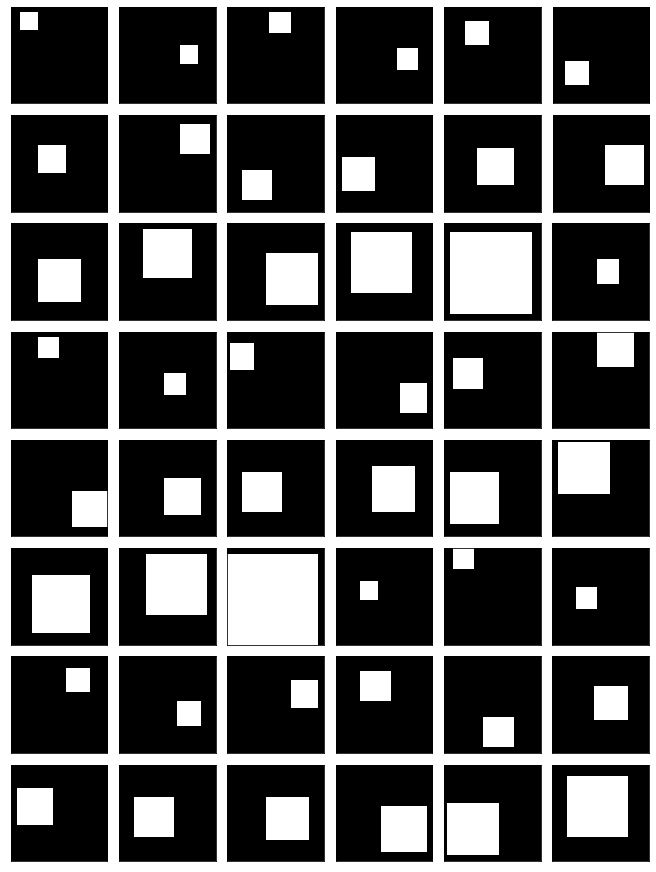


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the fake images]



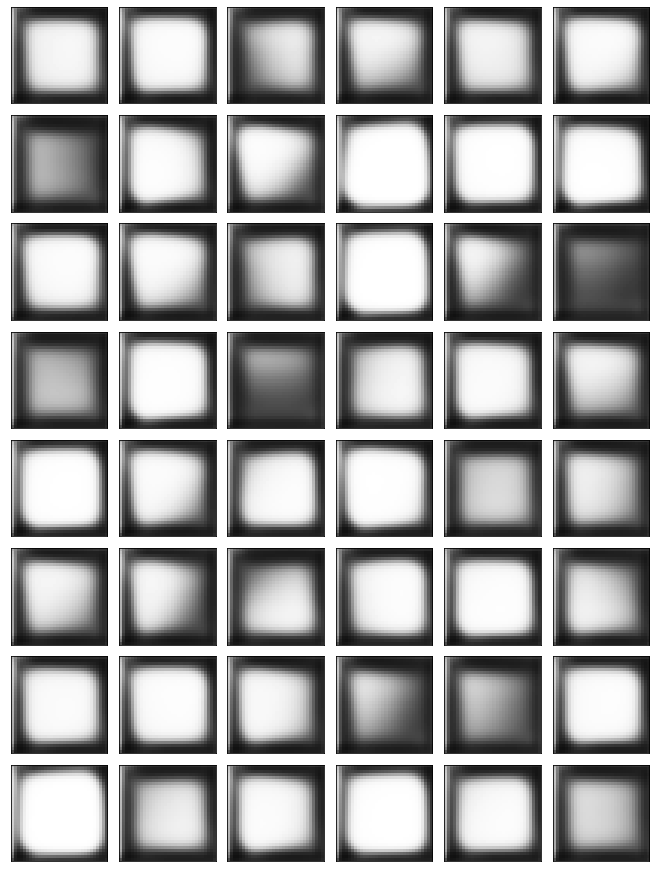


################################################################################
#
# RESULT # 03
#
################################################################################

[plot the generator loss]



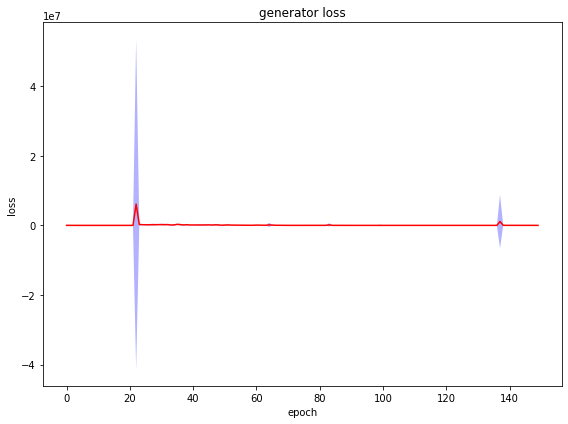


################################################################################
#
# RESULT # 04
#
################################################################################

[plot the discriminator loss]



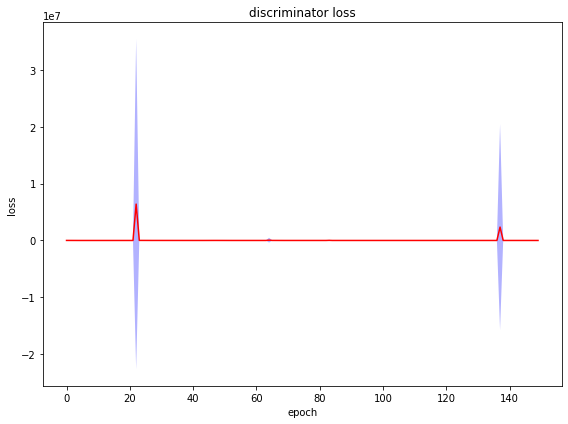


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the accuracy]



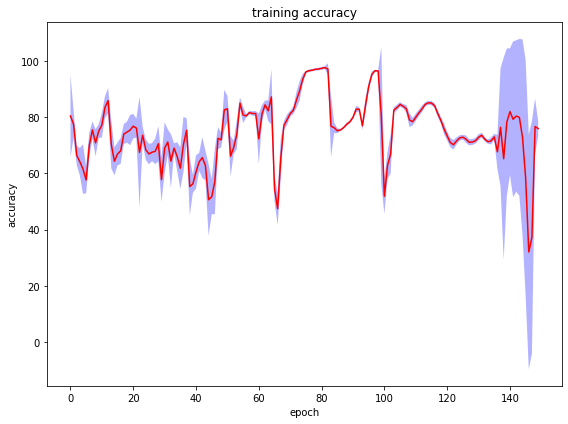


################################################################################
#
# RESULT # 06
#
################################################################################

[print the generator loss at the last 10 epochs]

index =  0, value = 6051.9639807413
index =  1, value = 4927.9293591403
index =  2, value = 7144.2915777162
index =  3, value = 5573.4523256287
index =  4, value = 6516.2039761802
index =  5, value = 6358.8017216172
index =  6, value = 6990.8076488879
index =  7, value = 5977.2043410900
index =  8, value = 5079.5340719297
index =  9, value = 4698.3709263765

################################################################################
#
# RESULT # 07
#
################################################################################

[print the discriminator loss at the last 10 epochs]

index =  0, value = 112.2471210841
index =  1, value = 66.9491732841
index =  2, value = 239.3380636434
index =  3, value = 158.1166441535
index =  4, value = 229.919251253

In [62]:
number_result = 9

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)